In [1]:
import sys
import warnings
#from torchtext import data

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

from keras import backend as K
import keras
import os, re, sys
import pandas as pd
from keras.utils import to_categorical
import ast
from sklearn.utils import class_weight
from keras.preprocessing import sequence
from keras.models import load_model
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk import WordNetLemmatizer
import itertools
from collections import Counter
from os import listdir
from os.path import isfile, join
import  json


Using TensorFlow backend.


## Generación de data Train/Val/test

In [2]:
stoplist = stopwords.words('english')
lemmatizer=WordNetLemmatizer()

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def cleaner(post):       
    s= re.sub(r"http\S+", " <url> ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " <hashtag> ", s) ########3
    s= re.sub(r'@\w+ ?', " <user> ", s)##############    
    s= s.lower()
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9][0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9][0-9][0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9][0-9][0-9][0-9]\b', " <number> ",  s)
    s=emoji_pattern.sub(r'', s)
    s= list(s.split())
    s=[lemmatizer.lemmatize(token) for token in s]
        
    return s

In [3]:
df_train=pd.read_csv("Train_data_compeition.csv")
df_val=pd.read_csv("Validation_data_competition.csv")
df_test=pd.read_csv("testset-competition.csv")
df_train.head()

,Unnamed: 0,tweet_content,harassment,IndirectH,PhysicalH,SexualH
0,0,pics mexican school girl naked melanie safka f...,1,0,0,1
1,1,RT shereiqns Having curly hair is a gotdamn ch...,0,0,0,0
2,2,BreakingNews 7 Unexplained Prisoners Deaths M...,0,0,0,0
3,3,girl dirty quarterback latino pokemon young h...,1,0,0,1
4,4,miliondollameat sexting n ngirl daddy n nme l...,1,0,0,1


In [4]:
df_train.describe()

,Unnamed: 0,harassment,IndirectH,PhysicalH,SexualH
count,6374.00000,6374.000000,6374.000000,6374.000000,6374.000000
mean,3186.50000,0.425635,0.008629,0.011923,0.405083
std,1840.15964,0.494478,0.092497,0.108550,0.490947
min,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1593.25000,0.000000,0.000000,0.000000,0.000000
50%,3186.50000,0.000000,0.000000,0.000000,0.000000
75%,4779.75000,1.000000,0.000000,0.000000,1.000000
max,6373.00000,1.000000,1.000000,1.000000,1.000000


In [5]:
from collections import Counter
print ("conteo de tweets clase Harassment",Counter(df_train['harassment']))
print ("conteo de tweets clase IndirectH",Counter(df_train['IndirectH']))
print ("conteo de tweets clase PhysicalH",Counter(df_train['PhysicalH']))
print ("conteo de tweets clase SexualH",Counter(df_train['SexualH']))

conteo de tweets clase Harassment Counter({0: 3661, 1: 2713})
conteo de tweets clase IndirectH Counter({0: 6319, 1: 55})
conteo de tweets clase PhysicalH Counter({0: 6298, 1: 76})
conteo de tweets clase SexualH Counter({0: 3792, 1: 2582})


In [21]:
y_train_bi=df_train['harassment'].values
y_train_bi[:20]
#labels_mul= 0:non-harassment, 1:harassment, 2:IndirectH, 3:PhysicalH, 4:SexualH


array([1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0])

In [22]:
type(y_train_bi)

numpy.ndarray

In [23]:
y_train_bic=to_categorical(y_train_bi,num_classes=2)
print (y_train_bic[0:10])
y_train_bic.shape

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


(6374, 2)

In [24]:
ys=df_train.values[:,2:]

y_train_mul=np.zeros((df_train.shape[0],5))
i=0
for label in ys:
    if np.sum(label)==0:
        y_train_mul[i][0]=1
    else: 
        y_train_mul[i]=np.concatenate([[0,0],label[1:]])
    i+=1
y_train_mul

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [25]:
y_train_mul[:20]

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [10]:
data_train=[]
for tw in df_train['tweet_content']:
    data_train.append(cleaner(tw))
print (data_train[:5])

[['pic', 'mexican', 'school', 'girl', 'naked', 'melanie', 'safka', 'fake', 'nude', 'photo', 'hardcore', 'slut', 'movie', 'alicia', 'moore', 'porn', 'star', 'toon', 'love'], ['rt', 'shereiqns', 'having', 'curly', 'hair', 'is', 'a', 'gotdamn', 'chore', 'do', 'not', 'let', 'the', 'internet', 'fool', 'you', 'ok'], ['breakingnews', '<number>', 'unexplained', 'prisoner', 'death', 'murder', 'amp', '<number>', 'attempted', 'suicide', 'samswey', 'shacking', 'sifill', 'ldf'], ['girl', 'dirty', 'quarterback', 'latino', 'pokemon', 'young', 'handjob', 'kissing', 'gangbang', 'w', 'x89', 't', 'co', 'wrm4xo00vj'], ['miliondollameat', 'sexting', 'n', 'ngirl', 'daddy', 'n', 'nme', 'listen', 'bitch', 'gonna', 'watch', 'these', 'what']]


In [11]:
embeddings_index = {}
f = open(os.path.join("/home/cony/Documentos/Milenio/twitter15/glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

Se encontraron 1193514 terminos con sus vectores de embedding.


In [12]:
word_index=dict()
j=1
for frase in data_train:
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1
    
len(word_index.keys())

16188

In [13]:
embedding_vector=200
embedding_matrix = np.zeros((len(word_index.keys())+1, embedding_vector))   #puede probar otra inicialización

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector



In [26]:
Counter(y_train_bi)

Counter({0: 3661, 1: 2713})

In [27]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_bi), y_train_bi)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)

[0.87052718 1.17471434]


In [28]:
from keras.preprocessing import sequence

x_new_train = [[word_index[word] for word in text] for text in data_train]
print(x_new_train[0:2])

print (data_train[0])
print (data_train[1])

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]]
['pic', 'mexican', 'school', 'girl', 'naked', 'melanie', 'safka', 'fake', 'nude', 'photo', 'hardcore', 'slut', 'movie', 'alicia', 'moore', 'porn', 'star', 'toon', 'love']
['rt', 'shereiqns', 'having', 'curly', 'hair', 'is', 'a', 'gotdamn', 'chore', 'do', 'not', 'let', 'the', 'internet', 'fool', 'you', 'ok']


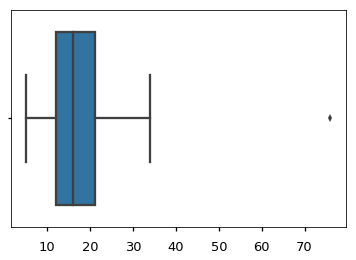

In [29]:
import seaborn as sns
sns.boxplot(list(map(len,x_new_train)))

In [30]:
max_input_lenght = max(list(map(len,x_new_train))) #modificar este valor en base a su experimentación
X_train = sequence.pad_sequences(x_new_train,maxlen=max_input_lenght,padding='post',value=0)
print (max_input_lenght) 
X_train.shape

76


(6374, 76)

#### Carga data Validación

In [54]:
print ("conteo de tweets clase Harassment",Counter(df_val['harassment']))
print ("conteo de tweets clase IndirectH",Counter(df_val['IndirectH']))
print ("conteo de tweets clase PhysicalH",Counter(df_val['PhysicalH']))
print ("conteo de tweets clase SexualH",Counter(df_val['SexualH']))
y_val_bin=df_val['harassment'].values
y_val_bin[:20]

conteo de tweets clase Harassment Counter({0: 1493, 1: 632})
conteo de tweets clase IndirectH Counter({0: 2054, 1: 71})
conteo de tweets clase PhysicalH Counter({0: 2089, 1: 36})
conteo de tweets clase SexualH Counter({0: 1600, 1: 525})


array([0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1])

In [55]:
ys_v=df_val.values[:,2:]

y_val_mul=np.zeros((df_val.shape[0],5))
i=0
for label in ys_v:
    if np.sum(label)==0:
        y_val_mul[i][0]=1
    else: 
        y_val_mul[i]=np.concatenate([[0,0],label[1:]])
    i+=1
y_val_mul

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [56]:
data_val=[]
for tw in df_val['tweet_content']:
    data_val.append(cleaner(tw))
print (data_val[:5])

[['rt', 'glossphoenix', 'some', 'of', 'y', 'all', 'never', 'watched', 'collected', 'and', 'fucked', 'with', 'the', 'bratz', 'movie', 'and', 'it', 'show'], ['omg', 'can', 't', 'believe', 'i', 'm', 'doing', 'this', 'selling', 'my', 'dropbox', 'folder', 'w', '<number>', 'nude', 'amp', '<number>', 'video', 'amp', 'dming', 'a', 'live', 'nude', 'f'], ['asa', 'akira', 'ava', 'lauren', 'beach', 'sex', 'free', 'porn', 'video', 'french', 'anal', 'ftm', 'porn', 'fuck', 'me', 'hard', 'mature', 'sex', 'milf', 'anal', 'pokemon', 'hent'], ['anyone', 'sassy', 'smart', 'mouth', 'cuuuuteeee', 'old', 'favorite', 'word', 'x89', 'x89', 'amp', 'x89', 'boo', 'x89', 'x9d', 'y', 'x89', 'all', 'sh', 'x89', 't', 'co', 'aqxguisj2x'], ['this', 'is', 'why', 'you', 're', 'scared', 'of', 'karma', 'you', 'got', 'to', 'know', 'it', 's', 'gonna', 'be', 'a', 'bitch', 'what', 'you', 'do', 'to', 'our', 'baby', 'will', 'happen']]


In [57]:
Counter(y_val_bin)

Counter({0: 1493, 1: 632})

In [58]:
Vec_train=[]
tweets_c_a=data_train
vocab_train=[]
vocab=list(embeddings_index.keys())
for post in tweets_c_a:
    posteo=[]
    for term in post:   #para todos los terminos de un tweet 
        vector=embeddings_index.get(term)
        if vector is None:       
            posteo.append(np.zeros(200))
        else:
            posteo.append(np.asarray(vector))
            vocab_train.append(term)
    Vec_train.append(np.asarray(posteo))

In [59]:
Vec_val_ig=[]
tweets_l_vali=data_val
vocab=list(embeddings_index.keys())
for post in tweets_l_vali:
    temp=[]
    for term in post:  
        if term in vocab_train:
            vector=embeddings_index.get(term)
            if vector is None:       
                temp.append(np.zeros(200))
            else:
                temp.append(np.asarray(vector))
    Vec_val_ig.append(temp)

In [60]:
df_val.shape

(2125, 6)

In [61]:
np.asarray(Vec_val_ig).shape

(2125,)

In [62]:
all_val=[]
for text in data_val:
    temp=[]
    for word in text:
        try:
            temp.append(word_index[word])
        except:
            continue
    all_val.append(temp)

In [63]:
x_new_val=all_val

print(x_new_val[0:2])
print (data_val[:2])
len(all_val)


[[20, 1526, 422, 438, 393, 664, 159, 12417, 142, 367, 318, 32, 13, 142, 95, 192], [3413, 94, 60, 521, 97, 143, 122, 117, 1407, 113, 1408, 58, 38, 9, 43, 38, 443, 43, 1976, 26, 111, 9, 282]]
[['rt', 'glossphoenix', 'some', 'of', 'y', 'all', 'never', 'watched', 'collected', 'and', 'fucked', 'with', 'the', 'bratz', 'movie', 'and', 'it', 'show'], ['omg', 'can', 't', 'believe', 'i', 'm', 'doing', 'this', 'selling', 'my', 'dropbox', 'folder', 'w', '<number>', 'nude', 'amp', '<number>', 'video', 'amp', 'dming', 'a', 'live', 'nude', 'f']]


2125

In [64]:
X_val_ig = sequence.pad_sequences(x_new_val,maxlen=max_input_lenght,padding='post',value=0)
print (np.asarray(X_val_ig).shape)

(2125, 76)


In [65]:
y_val_bin[:5]

array([0, 0, 1, 0, 1])

In [66]:
y_val_bic=to_categorical(y_val_bin,num_classes=2)
print (y_val_bic[0:10])
y_val_bic.shape

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


(2125, 2)

In [44]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.preprocessing import normalize
import time

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Modelo Conv


In [45]:
from  keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, Input
from keras.models import Model

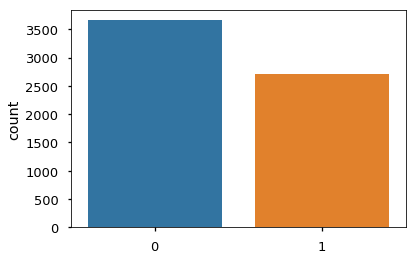

In [46]:
sns.countplot(y_train_bi)

In [47]:
from keras import backend as K

def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

In [67]:
embedding_vector=200
embedding_layer = Embedding(input_dim=len(word_index.keys())+1,output_dim=embedding_vector,weights=[embedding_matrix],
                     input_length=max_input_lenght,trainable=False)

sequence_input = Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)
batch = BatchNormalization()(embedded_sequences)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(64, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds = Dense(1, activation='sigmoid')(preds)
model = Model(sequence_input, preds)
#model.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 76)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 76, 200)           3237800   
_________________________________________________________________
batch_normalization_5 (Batch (None, 76, 200)           800       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 76, 128)           128128    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 25, 128)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 25, 128)           512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 25, 128)           0         
__________

In [68]:
X_train.shape

(6374, 76)

In [69]:
y_train_bi.shape

(6374,)

In [70]:
X_val_ig.shape

(2125, 76)

In [73]:
y_val_bic.shape

(2125, 2)

In [75]:
history = model.fit(X_train, y_train_bi,batch_size=64,epochs=10,verbose=1,validation_data=(X_val_ig,y_val_bin),class_weight=class_weights)

Train on 6374 samples, validate on 2125 samples
Epoch 1/10
6374/6374 [==============================] - 20s 3ms/step - loss: 0.5538 - acc: 0.7278 - val_loss: 0.3050 - val_acc: 0.8664
Epoch 2/10
6374/6374 [==============================] - 19s 3ms/step - loss: 0.3811 - acc: 0.8430 - val_loss: 0.3051 - val_acc: 0.8814
Epoch 3/10
6374/6374 [==============================] - 19s 3ms/step - loss: 0.3432 - acc: 0.8660 - val_loss: 0.3377 - val_acc: 0.8776
Epoch 4/10
6374/6374 [==============================] - 19s 3ms/step - loss: 0.3203 - acc: 0.8757 - val_loss: 0.3361 - val_acc: 0.8772
Epoch 5/10
6374/6374 [==============================] - 19s 3ms/step - loss: 0.2972 - acc: 0.8856 - val_loss: 0.3125 - val_acc: 0.8871
Epoch 6/10
6374/6374 [==============================] - 19s 3ms/step - loss: 0.2973 - acc: 0.8883 - val_loss: 0.3096 - val_acc: 0.8866
Epoch 7/10
6374/6374 [==============================] - 19s 3ms/step - loss: 0.2816 - acc: 0.8944 - val_loss: 0.3208 - val_acc: 0.8889
Epoch 8

In [78]:
y_val_bic[:4]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [81]:
trainPredict = model.predict(X_val_ig, batch_size=64)
print (trainPredict[:5])
trainPredict=[np.round(pred) for pred in trainPredict]
print (trainPredict[:5])
acc_val= accuracy_score(y_val_bin, trainPredict)
f1_val=f1_score(y_val_bin, trainPredict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_bin, trainPredict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_bin, trainPredict, average=None) 
pre=precision_score(y_val_bin, trainPredict, average=None) 
matriz_val=confusion_matrix(y_val_bin, trainPredict)

print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

[[0.00730522]
 [0.03075625]
 [0.94204664]
 [0.00331739]
 [0.30928892]]
[array([0.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32)]
Accuracy sobre validacion: 0.8823529411764706
F1-score None sobre validación: [0.92118537 0.76808905]
F1-score macro sobre validación: 0.8446372129041918
Precision None sobre validación: [0.87016081 0.92825112]
Recall None sobre validación: [0.97856664 0.65506329]


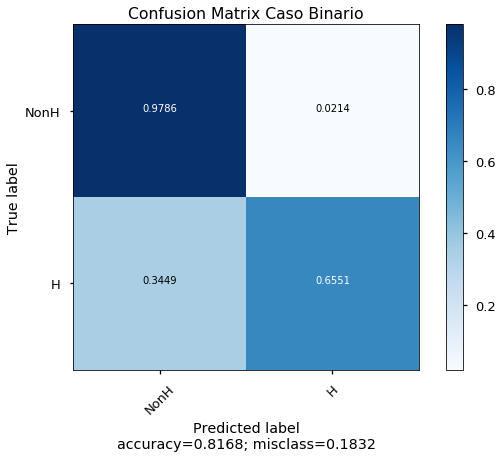

In [82]:
plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH","H"],"Confusion Matrix Caso Binario")

In [85]:
# lo mismo con focal 
embedding_vector=200
embedding_layer = Embedding(input_dim=len(word_index.keys())+1,output_dim=embedding_vector,weights=[embedding_matrix],
                     input_length=max_input_lenght,trainable=False)

sequence_input = Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)
batch = BatchNormalization()(embedded_sequences)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(64, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds = Dense(1, activation='sigmoid')(preds)
model = Model(sequence_input, preds)
model.compile(loss=focal_loss(2),optimizer='adam',metrics=['acc'])
#model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 76)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 76, 200)           3237800   
_________________________________________________________________
batch_normalization_13 (Batc (None, 76, 200)           800       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 76, 128)           128128    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 25, 128)           0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 25, 128)           512       
_________________________________________________________________
dropout_7 (Dropout)          (None, 25, 128)           0         
__________

In [86]:
history = model.fit(X_train, y_train_bi,batch_size=64,epochs=10,verbose=1,validation_data=(X_val_ig,y_val_bin),class_weight=class_weights)

Train on 6374 samples, validate on 2125 samples
Epoch 1/10
6374/6374 [==============================] - 20s 3ms/step - loss: 0.0770 - acc: 0.5703 - val_loss: 0.0147 - val_acc: 0.5666
Epoch 2/10
6374/6374 [==============================] - 19s 3ms/step - loss: 0.0176 - acc: 0.5590 - val_loss: 0.0076 - val_acc: 0.4287
Epoch 3/10
6374/6374 [==============================] - 19s 3ms/step - loss: 0.0073 - acc: 0.5119 - val_loss: 0.0019 - val_acc: 0.3369
Epoch 4/10
6374/6374 [==============================] - 19s 3ms/step - loss: 0.0036 - acc: 0.4998 - val_loss: 6.9480e-04 - val_acc: 0.3224
Epoch 5/10
6374/6374 [==============================] - 19s 3ms/step - loss: 0.0023 - acc: 0.4752 - val_loss: 4.2604e-04 - val_acc: 0.3144
Epoch 6/10
2048/6374 [========>.....................] - ETA: 11s - loss: 0.0016 - acc: 0.4678

KeyboardInterrupt: 

In [ ]:
trainPredict = model.predict(X_val_ig, batch_size=64)
print (trainPredict[:5])
trainPredict=[np.round(pred) for pred in trainPredict]
print (trainPredict[:5])
acc_val= accuracy_score(y_val_bin, trainPredict)
f1_val=f1_score(y_val_bin, trainPredict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_bin, trainPredict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_bin, trainPredict, average=None) 
pre=precision_score(y_val_bin, trainPredict, average=None) 
matriz_val=confusion_matrix(y_val_bin, trainPredict)

print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH","H"],"Confusion Matrix Caso Binario + Focal Loss")